# Classification based chunking

1. In previous tagger based chunking , we only used the (pos,iob) as feature we did not used the word to predict the chunk.
2. In classification based chunking we use the (word,tag) as input and we predict the iob.
3. we can also add some feature to classification  based chunking like currretn word ,current pos,previous word , previous pos,previous iob,next word , next tag.

In [11]:
import nltk

# corpus
from nltk.corpus import treebank_chunk

# nlp
from nltk.tag import ClassifierBasedTagger
from nltk.chunk import ChunkParserI
from nltk.chunk.util import tree2conlltags,conlltags2tree

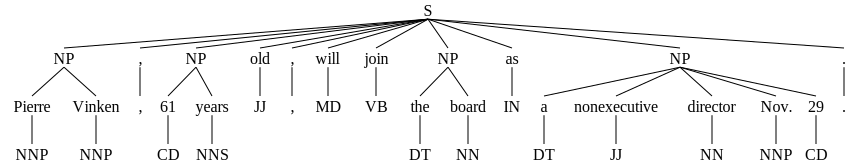

In [5]:
(treebank_chunk.chunked_sents()[0])

In [6]:
print(treebank_chunk.chunked_sents()[0])

(S
  (NP Pierre/NNP Vinken/NNP)
  ,/,
  (NP 61/CD years/NNS)
  old/JJ
  ,/,
  will/MD
  join/VB
  (NP the/DT board/NN)
  as/IN
  (NP a/DT nonexecutive/JJ director/NN Nov./NNP 29/CD)
  ./.)


In [8]:
tree2conlltags(treebank_chunk.chunked_sents()[0])

[('Pierre', 'NNP', 'B-NP'),
 ('Vinken', 'NNP', 'I-NP'),
 (',', ',', 'O'),
 ('61', 'CD', 'B-NP'),
 ('years', 'NNS', 'I-NP'),
 ('old', 'JJ', 'O'),
 (',', ',', 'O'),
 ('will', 'MD', 'O'),
 ('join', 'VB', 'O'),
 ('the', 'DT', 'B-NP'),
 ('board', 'NN', 'I-NP'),
 ('as', 'IN', 'O'),
 ('a', 'DT', 'B-NP'),
 ('nonexecutive', 'JJ', 'I-NP'),
 ('director', 'NN', 'I-NP'),
 ('Nov.', 'NNP', 'I-NP'),
 ('29', 'CD', 'I-NP'),
 ('.', '.', 'O')]

In [47]:
def chunk_tree2train_chunk(chunk_sents):
    tag_sents = [tree2conlltags(sent) for sent in chunk_sents]
    return [[((w,t),c) for (w,t,c) in wtc]
            for wtc in tag_sents]
    
#? changing the format from (w,t,c) to ((w,t),c) format

In [48]:
chunk_tree2train_chunk(treebank_chunk.chunked_sents()[:1])

[[(('Pierre', 'NNP'), 'B-NP'),
  (('Vinken', 'NNP'), 'I-NP'),
  ((',', ','), 'O'),
  (('61', 'CD'), 'B-NP'),
  (('years', 'NNS'), 'I-NP'),
  (('old', 'JJ'), 'O'),
  ((',', ','), 'O'),
  (('will', 'MD'), 'O'),
  (('join', 'VB'), 'O'),
  (('the', 'DT'), 'B-NP'),
  (('board', 'NN'), 'I-NP'),
  (('as', 'IN'), 'O'),
  (('a', 'DT'), 'B-NP'),
  (('nonexecutive', 'JJ'), 'I-NP'),
  (('director', 'NN'), 'I-NP'),
  (('Nov.', 'NNP'), 'I-NP'),
  (('29', 'CD'), 'I-NP'),
  (('.', '.'), 'O')]]

In [55]:
def prev_next_pos_iob(tokens,index,history):
    # print(tokens,index,history)
    word,pos = tokens[index]
    
    if index == 0:
        prev_word,prev_pos,prev_iob = ("<START>",)*3
    else:
        prev_word,prev_pos = tokens[index-1]
        prev_iob = history[index-1]
    
    if len(tokens) - 1 == index:
        next_word,next_pos = ("<END>",) *2
    else:
        next_word,next_pos = tokens[index+1]
    
    features = {
        "word" :word,
        "pos" : pos,
        "next_word" : next_word,
        "next_pos": next_pos,
        "prev_word": prev_word,
        "prev_pos" : prev_pos,
        "prev_iob" : prev_iob
    }

    return features

In [62]:
class ClassifierChunker(ChunkParserI):
    def __init__(self,train_sents,feature_detector=prev_next_pos_iob,**kwargs) -> None:
        super().__init__()
        chunk = chunk_tree2train_chunk(train_sents)
        self.tagger = ClassifierBasedTagger(feature_detector=feature_detector,
                                            train=chunk,
                                            **kwargs)
        
    
    def parse(self, tokens):
        chunk = self.tagger.tag(tokens)
        return conlltags2tree([(w,t,c) for ((w,t),c) in chunk])
        

In [63]:
len(treebank_chunk.chunked_sents())

4009

In [64]:
train_data = treebank_chunk.chunked_sents()[:3000]
test_data = treebank_chunk.chunked_sents()[3000:]

In [65]:
chunker = ClassifierChunker(train_data)
score = chunker.accuracy(test_data)
score.accuracy()

0.9721733155838022

In [66]:
score.precision()

0.9258838793383068

In [67]:
score.recall()

0.9359016393442623

In [68]:
from nltk.corpus import conll2000
conll_train = conll2000.chunked_sents("train.txt")
conll_test = conll2000.chunked_sents("test.txt")

In [69]:
chunker = ClassifierChunker(conll_train)
score = chunker.accuracy(conll_test)
score.accuracy()

0.9264622074002153

In [70]:
score.precision(),score.recall()

(0.8737924310910219, 0.9007354620620346)

## Using different classifier builder

In [71]:
from nltk.classify import MaxentClassifier

max_ent_chunker = ClassifierChunker(train_data,classifier_builder = MaxentClassifier.train)

  ==> Training (100 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -1.09861        0.459
             2          -0.28326        0.961
             3          -0.16952        0.971
      Training stopped: keyboard interrupt
         Final          -0.12652        0.976


In [73]:
# reducing the iteration

builder = lambda tokens : MaxentClassifier.train(tokens,max_iter=10,min_lldelta=0.01)
max_ent_chunker = ClassifierChunker(train_data,classifier_builder = builder)

  ==> Training (10 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -1.09861        0.459
             2          -0.28326        0.961
             3          -0.16952        0.971
             4          -0.12652        0.976
             5          -0.10380        0.979
             6          -0.08960        0.981
         Final          -0.07978        0.983
